In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from math import ceil

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import gensim
from gensim.models import Word2Vec

from wordcloud import WordCloud


In [2]:
# Загрузка данных из файла Excel
file_path = '/content/sample_data/ks_23.xlsx'
df = pd.read_excel(file_path)
df

wo_stop
0          figma, ui, английский, язык, ux, android, ios
1      английский, язык, amocrm, телефония, программи...
2      пользователь, пк, adobe, photoshop, грамотный,...
3      деловой, коммуникация, грамотность, поиск, инф...
4      linux, postgresql, sql, ms, sql, java, oracle,...
...                                                  ...
10484    кибербезопасность, информационный, безопасность
10485                                            асу, тп
10486  администрирование, сетевой, оборудование, наст...
10487  linux, ci/, cd, pipeline, k8s, okd, ocp, менто...
10488  работа, команда, креативность, творческий, мыш...

[10489 rows x 1 columns]

In [3]:
# Используем модель word2vec для векторизации столбца навыков
sentences = [skill.split(",") for skill in df['wo_stop']]
preprocessed_skills = sentences

vector_size = 100
window = 15
min_count = 5

model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, seed=40, sg=1)

# Получение векторов для каждой строки навыков (усреднение векторов слов), так как в одной строке несколько навыков
def get_skill_vector(skill):
    vectors = [model.wv[word] for word in skill if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

skill_vectors = np.array([get_skill_vector(skill) for skill in preprocessed_skills])


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10489 samples in 0.002s...
[t-SNE] Computed neighbors for 10489 samples in 1.882s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10489
[t-SNE] Computed conditional probabilities for sample 2000 / 10489
[t-SNE] Computed conditional probabilities for sample 3000 / 10489
[t-SNE] Computed conditional probabilities for sample 4000 / 10489
[t-SNE] Computed conditional probabilities for sample 5000 / 10489
[t-SNE] Computed conditional probabilities for sample 6000 / 10489
[t-SNE] Computed conditional probabilities for sample 7000 / 10489
[t-SNE] Computed conditional probabilities for sample 8000 / 10489
[t-SNE] Computed conditional probabilities for sample 9000 / 10489
[t-SNE] Computed conditional probabilities for sample 10000 / 10489
[t-SNE] Computed conditional probabilities for sample 10489 / 10489
[t-SNE] Mean sigma: 0.298411
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1.562613
[t-SNE] KL 

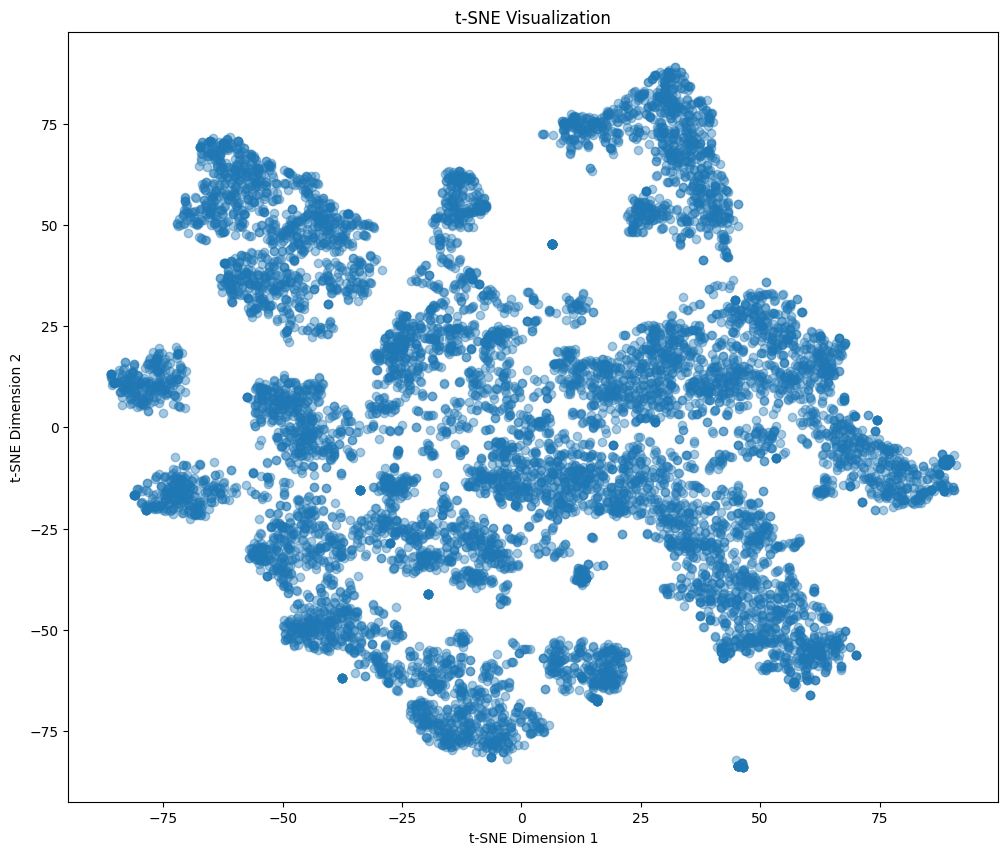

In [4]:
# Создание t-SNE модели для визуализации распределения навыков, параметры выбраны согласно размерам выборки
tsne_model = TSNE(n_components=2, random_state=42, verbose=1, early_exaggeration = 1, perplexity=50, learning_rate=800, n_iter=1000)
tsne_data = tsne_model.fit_transform(skill_vectors)

plt.figure(figsize=(12, 10))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.4)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [5]:
# Кластеризация K-means
def clusterize_skills(num_clusters, data):
    kmeans_cluster = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_labels = kmeans_cluster.fit_predict(data)
    return kmeans_labels

# Перебор числа кластеров от 5 до 40
results_KM = []
for num_clusters in range(5, 41):
    print(f"Clustering in progress for {num_clusters} clusters...")
    kmeans_labels = clusterize_skills(num_clusters, skill_vectors)
    print(f"Clustering completed for {num_clusters} clusters.")

    silhouette_avg_KM = silhouette_score(skill_vectors, kmeans_labels) # Рассчет силуэта

    davies_bouldin_KM = davies_bouldin_score(skill_vectors, kmeans_labels) # Рассчет индекса Дэвиcа-Боулдина

    calinski_harabasz_KM = calinski_harabasz_score(skill_vectors, kmeans_labels) # Рассчет Calinski-Harabasz Index

    results_KM.append([num_clusters, silhouette_avg_KM, davies_bouldin_KM, calinski_harabasz_KM])

results_df_KM = pd.DataFrame(results_KM, columns=['Num Clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

print(results_df_KM)

Clustering in progress for 5 clusters...
Clustering completed for 5 clusters.
Clustering in progress for 6 clusters...
Clustering completed for 6 clusters.
Clustering in progress for 7 clusters...
Clustering completed for 7 clusters.
Clustering in progress for 8 clusters...
Clustering completed for 8 clusters.
Clustering in progress for 9 clusters...
Clustering completed for 9 clusters.
Clustering in progress for 10 clusters...
Clustering completed for 10 clusters.
Clustering in progress for 11 clusters...
Clustering completed for 11 clusters.
Clustering in progress for 12 clusters...
Clustering completed for 12 clusters.
Clustering in progress for 13 clusters...
Clustering completed for 13 clusters.
Clustering in progress for 14 clusters...
Clustering completed for 14 clusters.
Clustering in progress for 15 clusters...
Clustering completed for 15 clusters.
Clustering in progress for 16 clusters...
Clustering completed for 16 clusters.
Clustering in progress for 17 clusters...
Clusteri

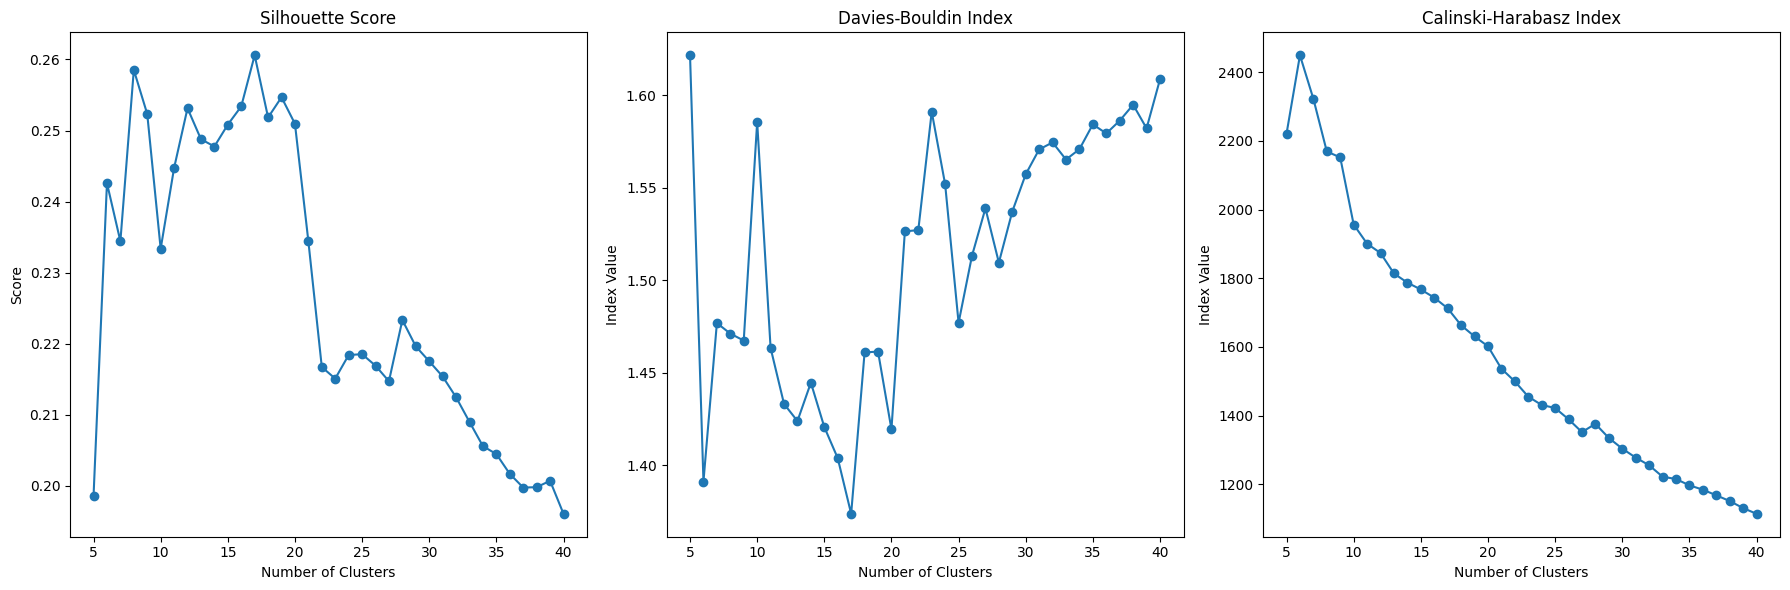

In [6]:
# Создание графиков для SS, DBI, CHI
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(results_df_KM['Num Clusters'], results_df_KM['Silhouette Score'], marker='o')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Score')

axes[1].plot(results_df_KM['Num Clusters'], results_df_KM['Davies-Bouldin Index'], marker='o')
axes[1].set_title('Davies-Bouldin Index')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Index Value')

axes[2].plot(results_df_KM['Num Clusters'], results_df_KM['Calinski-Harabasz Index'], marker='o')
axes[2].set_title('Calinski-Harabasz Index')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Index Value')

plt.tight_layout()
plt.show()


In [7]:
# Кластеризация AgglomerativeClustering
def clusterize_skills(num_clusters, data):
    agglomerative_cluster = AgglomerativeClustering(n_clusters=num_clusters)
    agglomerative_labels = agglomerative_cluster.fit_predict(data)
    return agglomerative_labels

# Перебор числа кластеров от 2 до 40
results_HC = []
for num_clusters in range(5, 41):
    print(f"Clustering in progress for {num_clusters} clusters...")
    agglomerative_labels = clusterize_skills(num_clusters, skill_vectors)
    print(f"Clustering completed for {num_clusters} clusters.")

    silhouette_avg_HC = silhouette_score(skill_vectors, agglomerative_labels)

    davies_bouldin_HC = davies_bouldin_score(skill_vectors, agglomerative_labels)

    calinski_harabasz_HC = calinski_harabasz_score(skill_vectors, agglomerative_labels)

    results_HC.append([num_clusters, silhouette_avg_HC, davies_bouldin_HC, calinski_harabasz_HC])

results_df_HC = pd.DataFrame(results_HC, columns=['Num Clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

print(results_df_HC)

Clustering in progress for 5 clusters...
Clustering completed for 5 clusters.
Clustering in progress for 6 clusters...
Clustering completed for 6 clusters.
Clustering in progress for 7 clusters...
Clustering completed for 7 clusters.
Clustering in progress for 8 clusters...
Clustering completed for 8 clusters.
Clustering in progress for 9 clusters...
Clustering completed for 9 clusters.
Clustering in progress for 10 clusters...
Clustering completed for 10 clusters.
Clustering in progress for 11 clusters...
Clustering completed for 11 clusters.
Clustering in progress for 12 clusters...
Clustering completed for 12 clusters.
Clustering in progress for 13 clusters...
Clustering completed for 13 clusters.
Clustering in progress for 14 clusters...
Clustering completed for 14 clusters.
Clustering in progress for 15 clusters...
Clustering completed for 15 clusters.
Clustering in progress for 16 clusters...
Clustering completed for 16 clusters.
Clustering in progress for 17 clusters...
Clusteri

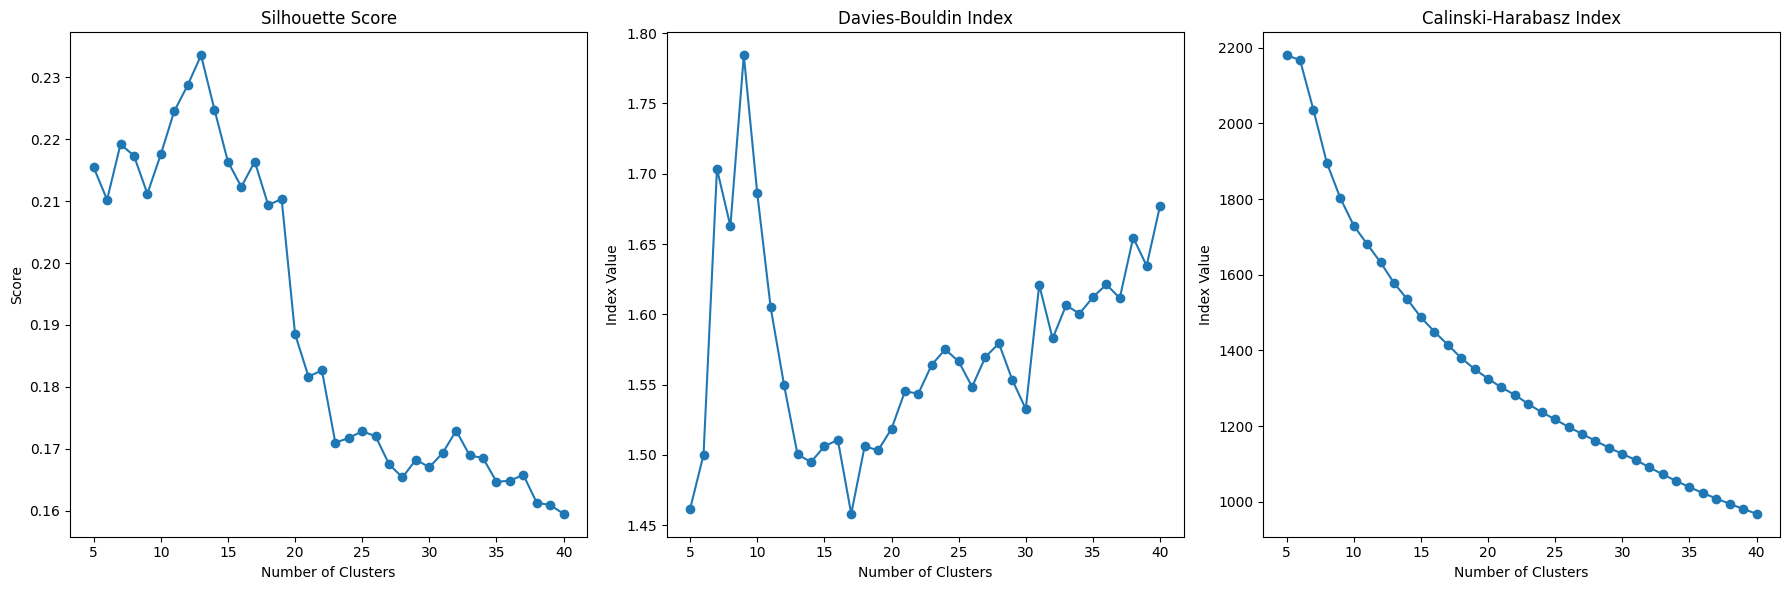

In [8]:
# Создание графиков для SS, DBI, CHI
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(results_df_HC['Num Clusters'], results_df_HC['Silhouette Score'], marker='o')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Score')

axes[1].plot(results_df_HC['Num Clusters'], results_df_HC['Davies-Bouldin Index'], marker='o')
axes[1].set_title('Davies-Bouldin Index')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Index Value')

axes[2].plot(results_df_HC['Num Clusters'], results_df_HC['Calinski-Harabasz Index'], marker='o')
axes[2].set_title('Calinski-Harabasz Index')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Index Value')

plt.tight_layout()
plt.show()


In [9]:
# Кластеризация SpectralClustering
def clusterize_skills(num_clusters, data):
    spectral_cluster = SpectralClustering(n_clusters=num_clusters, random_state=42, affinity='rbf')
    spectral_labels = spectral_cluster.fit_predict(data)
    return spectral_labels

# Перебор числа кластеров от 2 до 40
results_SC = []
for num_clusters in range(5, 41):
    print(f"Clustering in progress for {num_clusters} clusters...")
    spectral_labels = clusterize_skills(num_clusters, skill_vectors)
    print(f"Clustering completed for {num_clusters} clusters.")

    silhouette_avg_SC = silhouette_score(skill_vectors, spectral_labels)

    davies_bouldin_SC = davies_bouldin_score(skill_vectors, spectral_labels)

    calinski_harabasz_SC = calinski_harabasz_score(skill_vectors, spectral_labels)

    results_SC.append([num_clusters, silhouette_avg_SC, davies_bouldin_SC, calinski_harabasz_SC])

results_df_SC = pd.DataFrame(results_SC, columns=['Num Clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

print(results_df_SC)


Clustering in progress for 5 clusters...
Clustering completed for 5 clusters.
Clustering in progress for 6 clusters...
Clustering completed for 6 clusters.
Clustering in progress for 7 clusters...
Clustering completed for 7 clusters.
Clustering in progress for 8 clusters...
Clustering completed for 8 clusters.
Clustering in progress for 9 clusters...
Clustering completed for 9 clusters.
Clustering in progress for 10 clusters...
Clustering completed for 10 clusters.
Clustering in progress for 11 clusters...
Clustering completed for 11 clusters.
Clustering in progress for 12 clusters...
Clustering completed for 12 clusters.
Clustering in progress for 13 clusters...
Clustering completed for 13 clusters.
Clustering in progress for 14 clusters...
Clustering completed for 14 clusters.
Clustering in progress for 15 clusters...
Clustering completed for 15 clusters.
Clustering in progress for 16 clusters...
Clustering completed for 16 clusters.
Clustering in progress for 17 clusters...
Clusteri

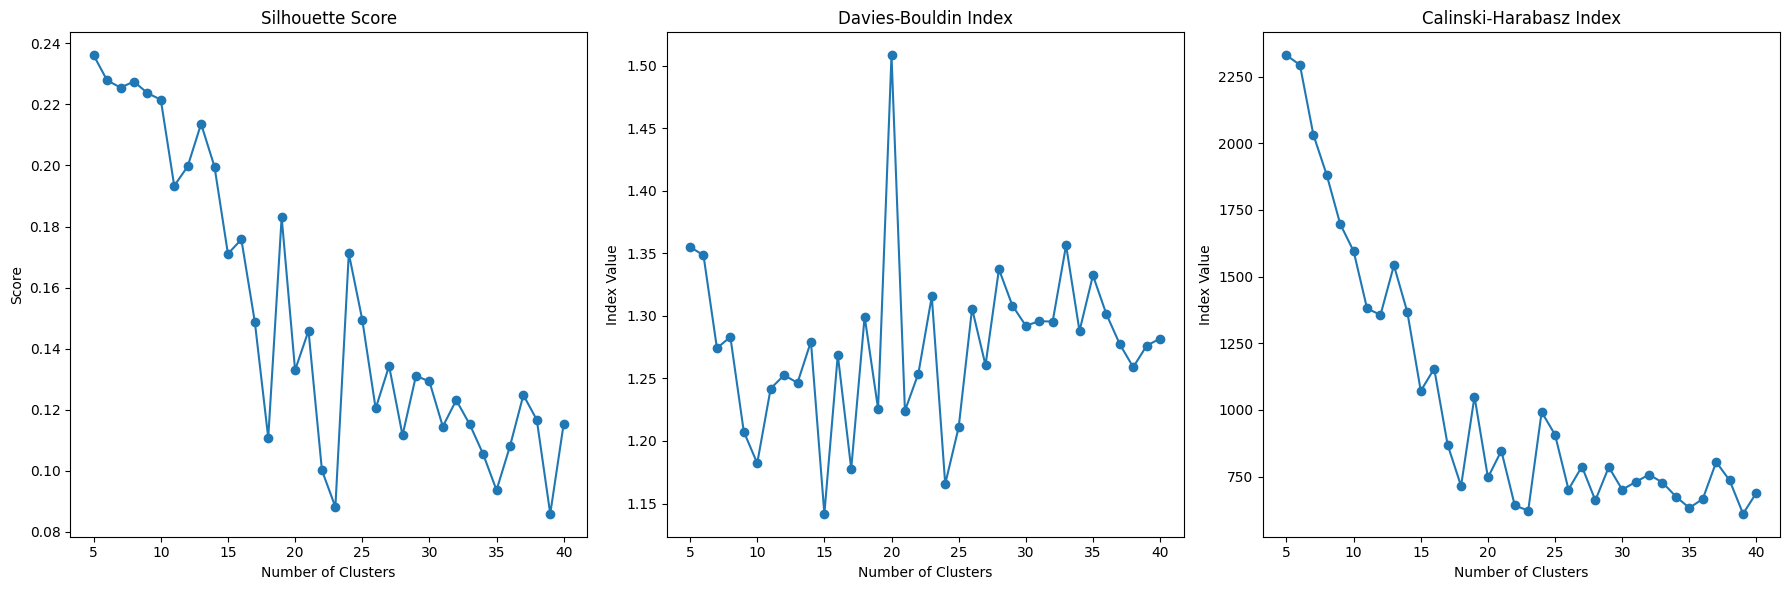

In [10]:
# Создание графиков для SS, DBI, CHI
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(results_df_SC['Num Clusters'], results_df_SC['Silhouette Score'], marker='o')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Score')

axes[1].plot(results_df_SC['Num Clusters'], results_df_SC['Davies-Bouldin Index'], marker='o')
axes[1].set_title('Davies-Bouldin Index')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Index Value')

axes[2].plot(results_df_SC['Num Clusters'], results_df_SC['Calinski-Harabasz Index'], marker='o')
axes[2].set_title('Calinski-Harabasz Index')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Index Value')

plt.tight_layout()
plt.show()


In [12]:
# Функция для нормализации всех метрик
def normalize_metrics(df):
    scaler = MinMaxScaler()
    df[['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']] = scaler.fit_transform(
        df[['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']]
    )
    return df

# Нормализуем метрики для каждой кластеризации
results_df_KM_norm = normalize_metrics(results_df_KM.copy())
results_df_HC_norm = normalize_metrics(results_df_HC.copy())
results_df_SC_norm = normalize_metrics(results_df_SC.copy())

all_results = pd.concat([results_df_KM_norm, results_df_HC_norm, results_df_SC_norm])

# Задаём ограничиваем только числа кластеров >= 10 и определяем комбинированный рейтинг (среднее нормализованное), затем определяем оптимальное число кластеров для всех кластеризаций
filtered_results = all_results[all_results['Num Clusters'] >= 10]
filtered_results.loc[:, 'Combined Score'] = filtered_results[['Silhouette Score', 'Calinski-Harabasz Index']].mean(axis=1) - filtered_results['Davies-Bouldin Index']
optimal_clusters = filtered_results.groupby('Num Clusters')['Combined Score'].mean().idxmax()

print(f"Оптимальное число кластеров для Num Clusters >= 10: {optimal_clusters}")


Оптимальное число кластеров для Num Clusters >= 10: 13


<ipython-input-12-56fd36cf4a62>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results.loc[:, 'Combined Score'] = filtered_results[['Silhouette Score', 'Calinski-Harabasz Index']].mean(axis=1) - filtered_results['Davies-Bouldin Index']


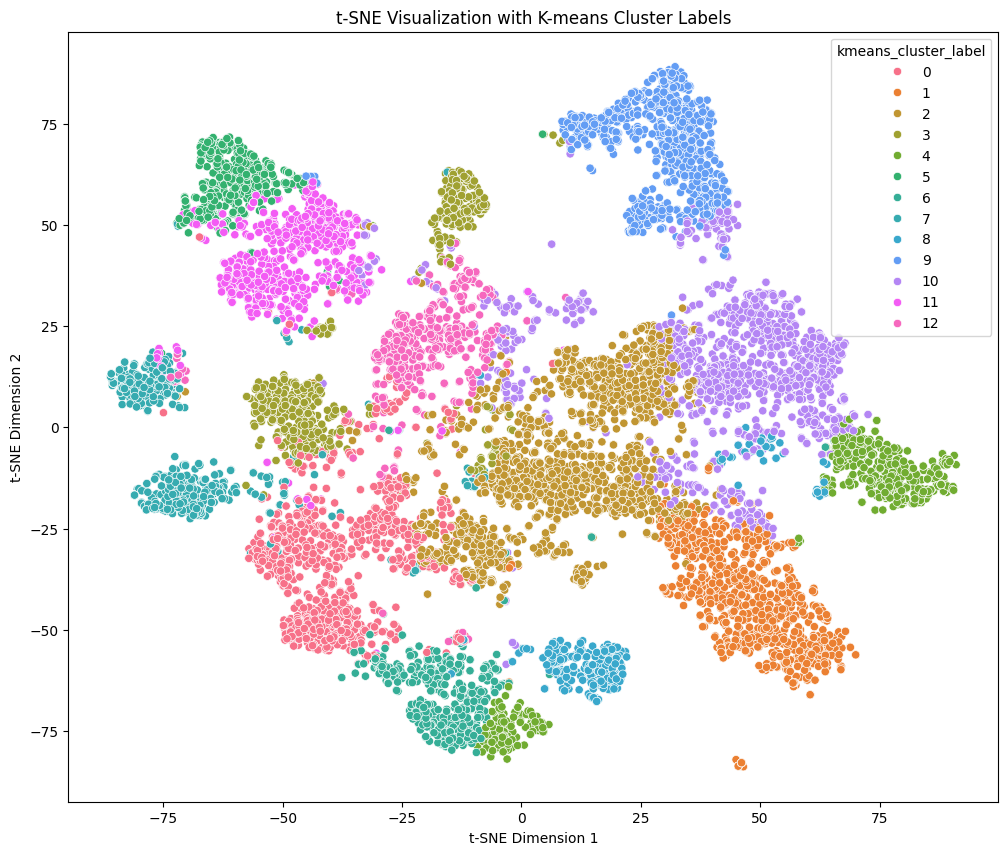

In [15]:
# Выполнение кластеризации K-means с числом кластеров 13
kmeans = KMeans(n_clusters=13, random_state=42)
kmeans_labels_13 = kmeans.fit_predict(skill_vectors)

# DF с результатами t-SNE и метками кластеров
tsne_df_kmeans = pd.DataFrame({
    'tsne_1': tsne_data[:, 0],
    'tsne_2': tsne_data[:, 1],
    'kmeans_cluster_label': kmeans_labels_13
})

custom_palette_kmeans = sns.color_palette("husl", 13)

plt.figure(figsize=(12, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='kmeans_cluster_label', data=tsne_df_kmeans, palette=custom_palette_kmeans, legend='full')
plt.title('t-SNE Visualization with K-means Cluster Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

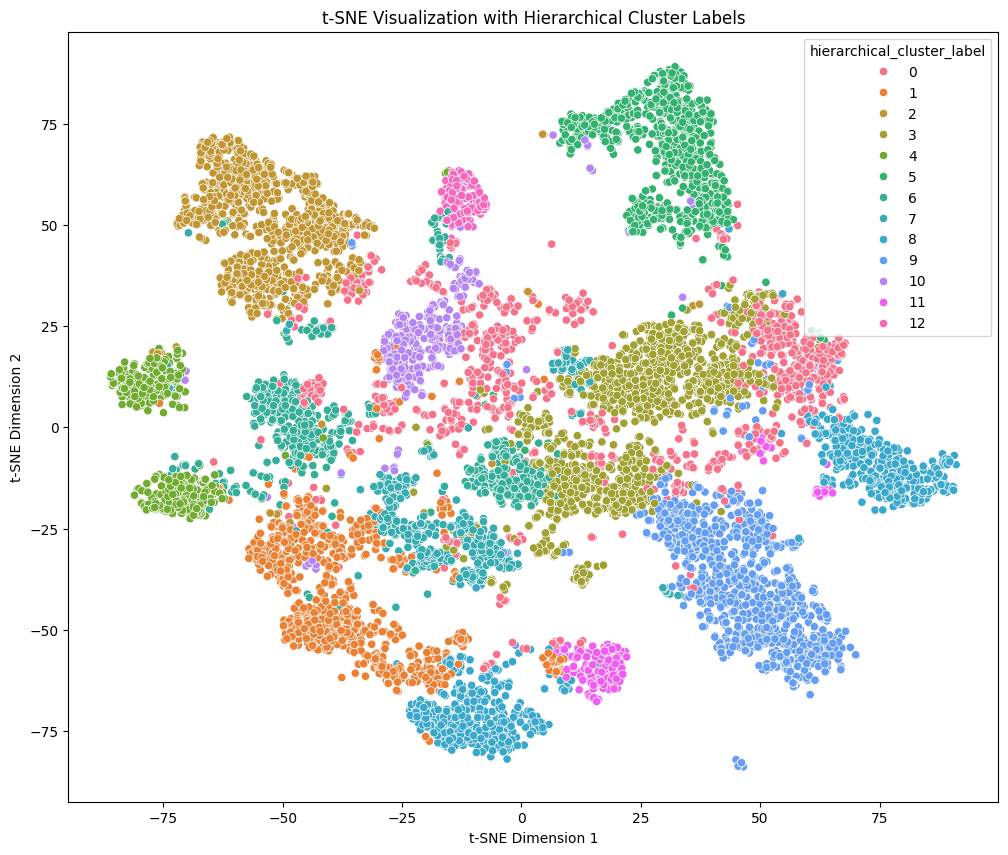

In [17]:
# Выполнение кластеризации и получение меток
hierarchical_cluster = AgglomerativeClustering(n_clusters=13, metric='euclidean', linkage='ward')
hierarchical_labels_13 = hierarchical_cluster.fit_predict(skill_vectors)

tsne_df_hierarchical = pd.DataFrame({
    'tsne_1': tsne_data[:, 0],
    'tsne_2': tsne_data[:, 1],
    'hierarchical_cluster_label': hierarchical_labels_13
})

custom_palette_hierarchical = sns.color_palette("husl", 13)

plt.figure(figsize=(12, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='hierarchical_cluster_label', data=tsne_df_hierarchical, palette=custom_palette_hierarchical, legend='full')
plt.title('t-SNE Visualization with Hierarchical Cluster Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


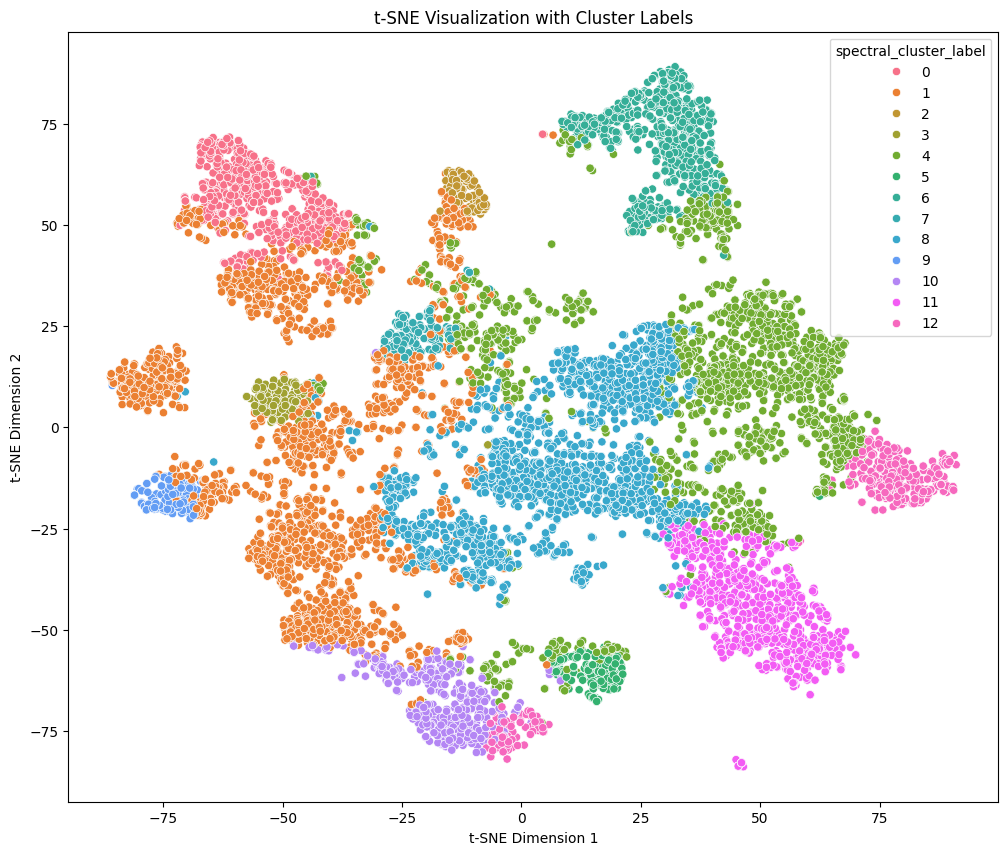

In [27]:
# Выполнение кластеризации и получение меток
spectral_cluster = SpectralClustering(n_clusters=13, random_state=42, affinity='rbf')
spectral_labels_13 = spectral_cluster.fit_predict(skill_vectors)

tsne_df = pd.DataFrame({
    'tsne_1': tsne_data[:, 0],
    'tsne_2': tsne_data[:, 1],
    'spectral_cluster_label': spectral_labels_13
})

custom_palette = sns.color_palette("husl", 13)

plt.figure(figsize=(12, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='spectral_cluster_label', data=tsne_df, palette=custom_palette, legend='full')
plt.title('t-SNE Visualization with Cluster Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


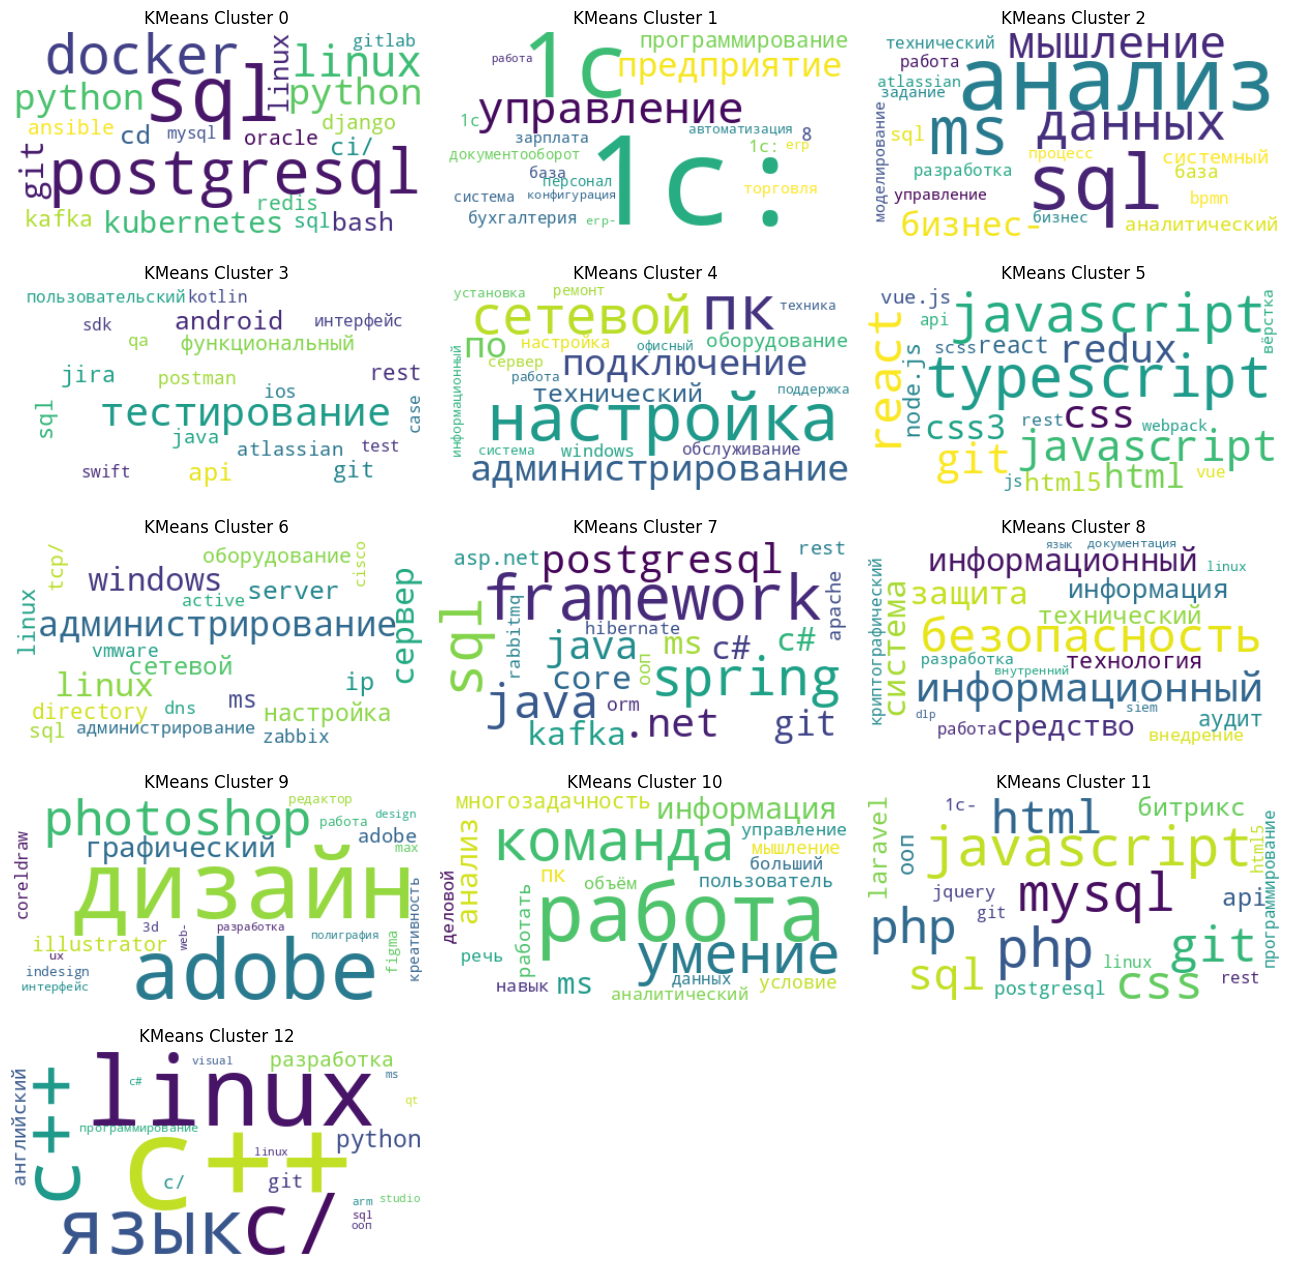

In [24]:
# Создание DF для навыков и меток кластеров K-means
cluster_df_KM = pd.DataFrame(skill_vectors, columns=[f"skill_vector_{i}" for i in range(skill_vectors.shape[1])])
cluster_df_KM['kmeans_cluster_label'] = kmeans_labels_13

# Получение уникальных меток кластеров
cluster_labels = sorted(cluster_df_KM['kmeans_cluster_label'].unique())
num_clusters = len(cluster_labels)
num_cols = 3
num_rows = ceil(num_clusters / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 13), squeeze=False)

for i, cluster_label in enumerate(cluster_labels):
    row_idx = i // num_cols
    col_idx = i % num_cols

    cluster_data = cluster_df_KM[cluster_df_KM['kmeans_cluster_label'] == cluster_label]

    # Условное объединение векторов для нахождения наиболее частых навыков в кластере
    # Получаем список навыков из соответствующих строк
    skills = df.loc[cluster_data.index, 'wo_stop'].str.split(",").sum()

    # Подсчет частоты навыков
    skill_counts = Counter(skills)

    # Получение 20 наиболее частых навыков
    top_skills = skill_counts.most_common(20)

    # Генерация облака слов
    terms_weights = {term: weight for term, weight in top_skills}

    wordcloud = WordCloud(width=400, height=200, background_color='white', collocations=False, max_words=20).generate_from_frequencies(terms_weights)

    # Визуализация облака слов
    axes[row_idx, col_idx].imshow(wordcloud, interpolation='bilinear')
    axes[row_idx, col_idx].set_title(f'KMeans Cluster {cluster_label}')
    axes[row_idx, col_idx].axis('off')

# Скрытие пустых ячеек
for i in range(num_clusters, num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

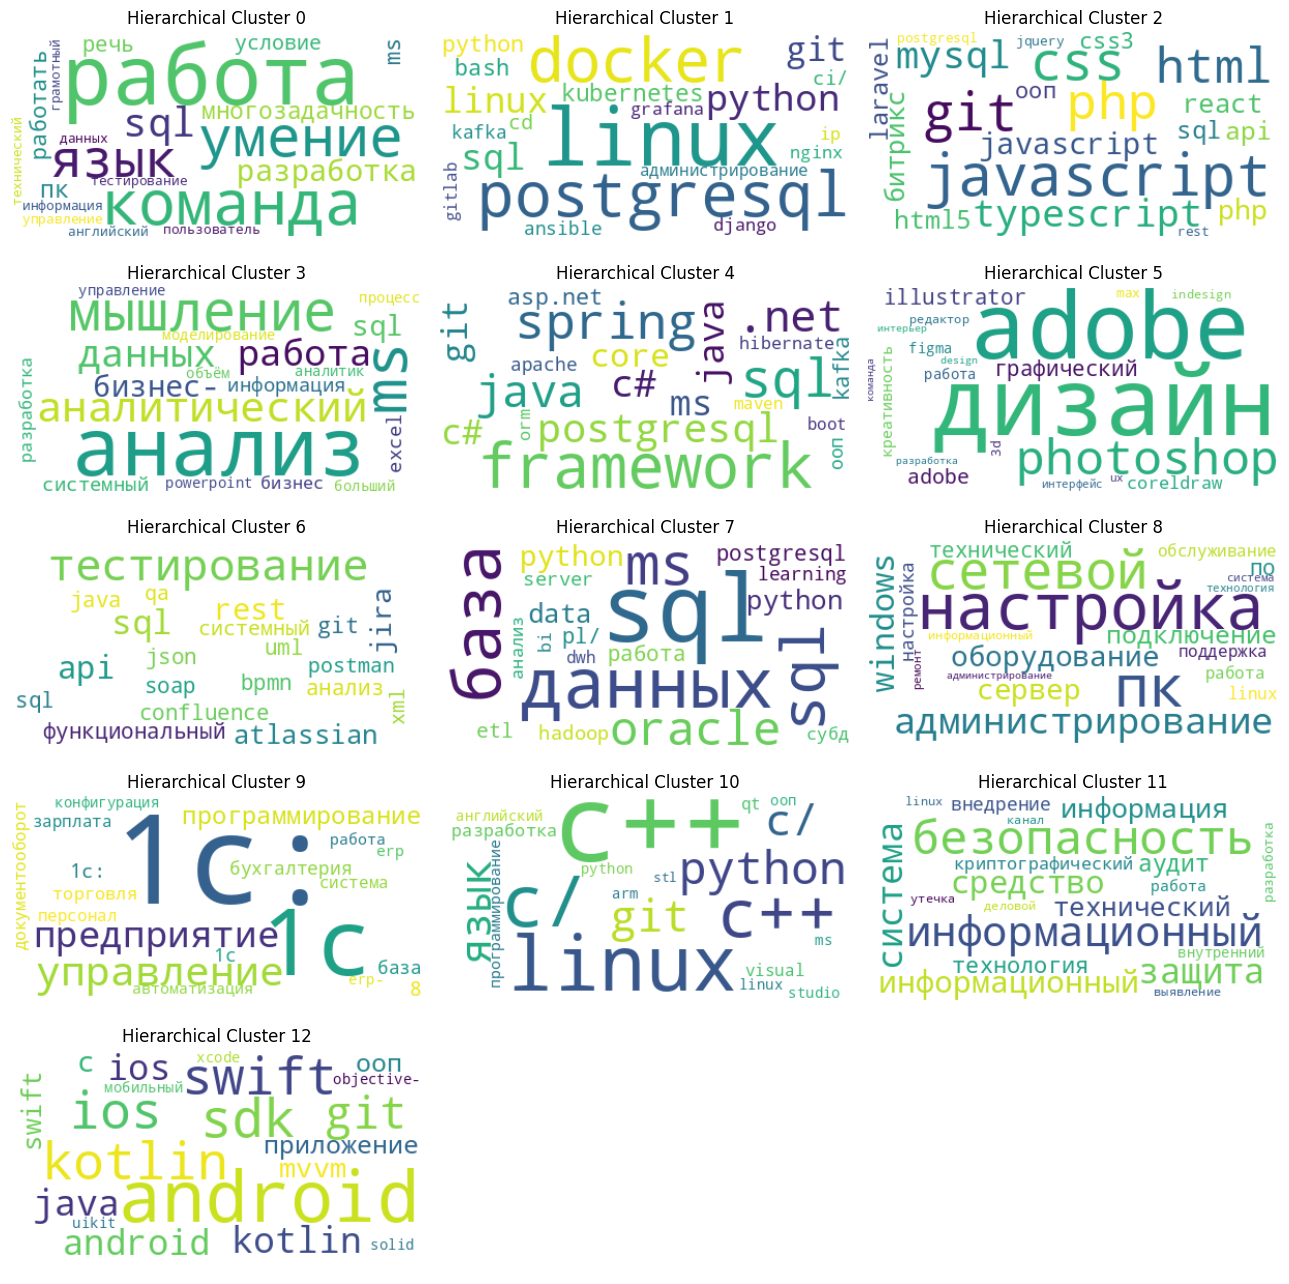

In [25]:
# Для HC
cluster_df_HC = pd.DataFrame(skill_vectors, columns=[f"skill_vector_{i}" for i in range(skill_vectors.shape[1])])
cluster_df_HC['hierarchical_cluster_label'] = hierarchical_labels_13

# Получение уникальных меток кластеров
cluster_labels = sorted(cluster_df_HC['hierarchical_cluster_label'].unique())
num_clusters = len(cluster_labels)
num_cols = 3
num_rows = ceil(num_clusters / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 13), squeeze=False)

for i, cluster_label in enumerate(cluster_labels):
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Выбор данных для текущего кластера
    cluster_data = cluster_df_HC[cluster_df_HC['hierarchical_cluster_label'] == cluster_label]

    # Условное объединение векторов для нахождения наиболее частых навыков в кластере
    # Получаем список навыков из соответствующих строк
    skills = df.loc[cluster_data.index, 'wo_stop'].str.split(",").sum()

    # Подсчет частоты навыков
    skill_counts = Counter(skills)

    # Получение 20 наиболее частых навыков
    top_skills = skill_counts.most_common(20)

    # Генерация облака слов
    terms_weights = {term: weight for term, weight in top_skills}

    wordcloud = WordCloud(width=400, height=200, background_color='white', collocations=False, max_words=20).generate_from_frequencies(terms_weights)

    # Визуализация облака слов
    axes[row_idx, col_idx].imshow(wordcloud, interpolation='bilinear')
    axes[row_idx, col_idx].set_title(f'Hierarchical Cluster {cluster_label}')
    axes[row_idx, col_idx].axis('off')

# Скрытие пустых ячеек
for i in range(num_clusters, num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

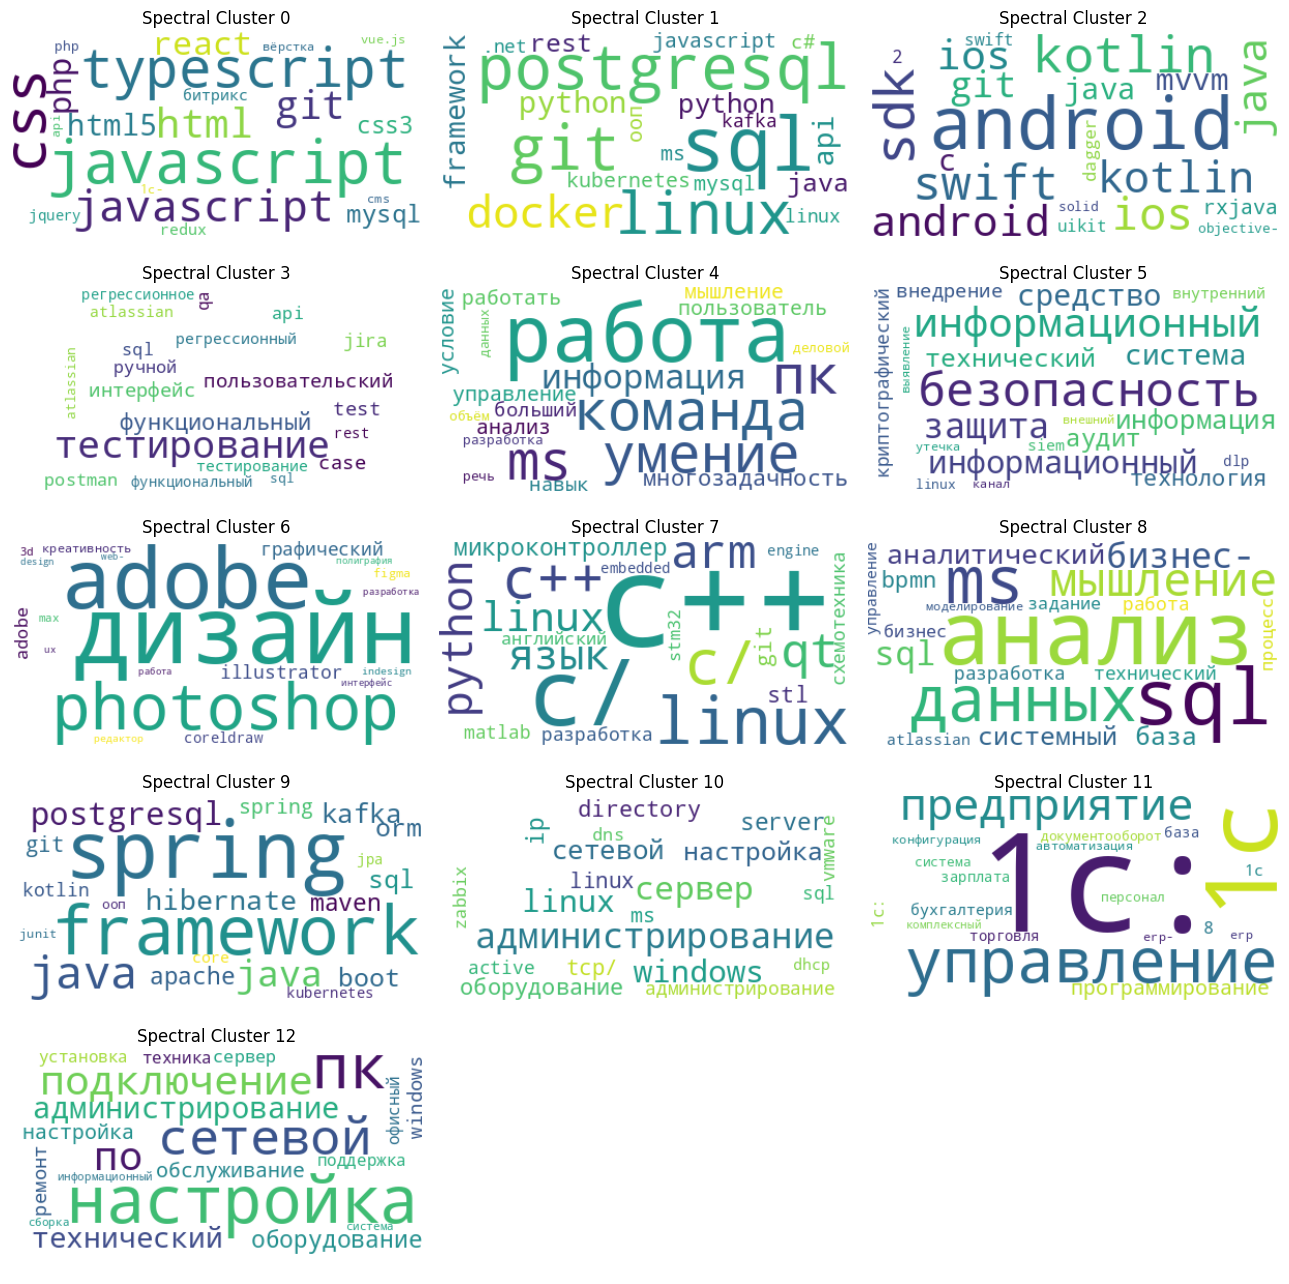

In [30]:
# Для SC
cluster_df_SC = pd.DataFrame(skill_vectors, columns=[f"skill_vector_{i}" for i in range(skill_vectors.shape[1])])
cluster_df_SC['spectral_cluster_label'] = spectral_labels_13

# Получение уникальных меток кластеров
cluster_labels = sorted(cluster_df_SC['spectral_cluster_label'].unique())
num_clusters = len(cluster_labels)
num_cols = 3
num_rows = ceil(num_clusters / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 13), squeeze=False)

for i, cluster_label in enumerate(cluster_labels):
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Выбор данных для текущего кластера
    cluster_data = cluster_df_SC[cluster_df_SC['spectral_cluster_label'] == cluster_label]

    # Условное объединение векторов для нахождения наиболее частых навыков в кластере
    # Получаем список навыков из соответствующих строк
    skills = df.loc[cluster_data.index, 'wo_stop'].str.split(",").sum()

    # Подсчет частоты навыков
    skill_counts = Counter(skills)

    # Получение 20 наиболее частых навыков
    top_skills = skill_counts.most_common(20)

    # Генерация облака слов
    terms_weights = {term: weight for term, weight in top_skills}

    wordcloud = WordCloud(width=400, height=200, background_color='white', collocations=False, max_words=20).generate_from_frequencies(terms_weights)

    # Визуализация облака слов
    axes[row_idx, col_idx].imshow(wordcloud, interpolation='bilinear')
    axes[row_idx, col_idx].set_title(f'Spectral Cluster {cluster_label}')
    axes[row_idx, col_idx].axis('off')

# Скрытие пустых ячеек
for i in range(num_clusters, num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()